In [67]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()  # Enable progress_apply with progress bar in Jupyter environments
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from gensim.matutils import Sparse2Corpus
from gensim import models
from scipy.sparse import csr_matrix


In [148]:
df = pd.read_excel('combined.xlsx')
df.head(20)

Date                             Source  \
0  2022-09-30 22:08:34     Il Messaggero - Borsa Italiana   
1  2022-09-30 21:44:15  Puls Biznesu - Z ostatniej chwili   
2  2022-09-30 21:30:13            Handelsblatt - Finanzen   
3  2022-09-30 21:07:32                     Trend - Správy   
4  2022-09-30 20:56:08                  Bloomberg - GNews   
5  2022-09-30 19:47:02                      Trend. - Home   
6  2022-09-30 19:17:43  Rai News 24  - Economia e finanza   
7  2022-09-30 19:11:05                            Tgcom24   
8  2022-09-30 19:11:05                            Tgcom24   
9  2022-09-30 18:53:08                       Der Aktionär   
10 2022-09-30 18:46:15                            Tgcom24   
11 2022-09-30 18:42:47                 Il Foglio - Page 3   
12 2022-09-30 18:39:39  Affaritaliani Libero - Notiziario   
13 2022-09-30 18:32:37                  Finance.si - Live   
14 2022-09-30 18:25:42                 Il Foglio - Page 3   
15 2022-09-30 18:25:13            Handelsblatt - Finanzen   
16 2022-09-30 18:23:18                            Tgcom24   
17 2022-09-30 18:23:02  Affaritaliani Libero - Notiziario   
18 2022-09-30 18:19:40                 Il Foglio - Page 2   
19 2022-09-30 18:12:29                            Tgcom24   

                                             Headline  \
0   Visco: «Troppi rialzi dei tassi, si va in rece...   
1      Knot: kolejne podwyżki stóp  EBC  są konieczne   
2   EZB-Ratsmitglied Visco: Rezessionsrisiko bei g...   
3   ECB  by mala byť pri zvyšovaní sadzieb opatrná...   
4   ECB 's Schnabel Says Weaker Demand May Not Eas...   
5      EZB-Direktorin Schnabel für "robustes" Handeln   
6   Visco: "Lo shock energetico è un onere ineludi...   
7   Bce: Schnabel, necessari ulteriori rialzi dei ...   
8   Bce: Schnabel non vede rischio spirale salari-...   
9   EZB ‑Geldpolitik: Ratsmitglied Visco warnt vor...   
10    Energia: Visco, shock ineludibile per area euro   
11  **Conti pubblici: Visco, rientro debito ben in...   
12  **Conti pubblici: Visco, rientro debito ben in...   
13  Evrska inflacija na novem rekordu. Bo  ECB  ok...   
14  Bce: Visco, 'su rialzo tassi opportuno muovers...   
15  EZB-Direktorin Schnabel fordert wegen Rekordin...   
16  Inflazione: Visco, no segnali avvio pericolose...   
17  Bce: Visco, 'su rialzo tassi opportuno muovers...   
18  **Bce: Visco, 'rialzo tassi troppo rapido e fo...   
19  Bce: Visco, non ha ritardato riequilibrio poli...   

                                  Translated.headline  \
0   Banca d'Italia's Visco: "Too many rate hikes w...   
1        Knot: further  ECB  rate hikes are necessary   
2   ECB 's Visco: Recession risk in the event of m...   
3   ECB  should be cautious about rate hikes, says...   
4   ECB 's Schnabel says weaker demand may not eas...   
5   ECB  Executive Board Member Schnabel is for "r...   
6   Visco: "Energy shock is an unavoidable burden....   
7        ECB : Schnabel, further rate hikes necessary   
8   ECB : Schnabel sees no risk of spiraling wages...   
9   ECB  monetary policy: Council member Visco war...   
10     Energy: Visco, inescapable shock for euro area   
11  Public accounts: Visco, debt repayment well ad...   
12  Public accounts: Visco, debt repayment well ad...   
13  Euro area inflation on a new record. Will the ...   
14  ECB , Visco: “it is appropriate to move gradua...   
15  ECB  Executive Board Member Schnabel calls for...   
16  Inflation: Visco, no signs start dangerous pri...   
17  ECB : Visco, when rising rates it is appropria...   
18  ECB , Visco: too rapid and strong rate hike ca...   
19  ECB : Visco, did not delay monetary policy reb...   

                                       Manual.summary  \
0   At a conference in Florence, Banca d'Italia Go...   
1                                                 NaN   
2   Banca d'Italia Governor  Ignazio Visco  on Fri...   
3                                                 NaN   
4   ECB  Executive Board Member  Isabel Schnabel  ...  

# EDA

In [149]:
df.shape

(35076, 15)

In [150]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35076 entries, 0 to 35075
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  35076 non-null  datetime64[ns]
 1   Source                35076 non-null  object        
 2   Headline              34955 non-null  object        
 3   Translated.headline   35034 non-null  object        
 4   Manual.summary        31384 non-null  object        
 5   Original.article.url  35076 non-null  object        
 6   Media.type            35076 non-null  object        
 7   Speaker               34768 non-null  object        
 8   Reach                 35076 non-null  int64         
 9   Language              35071 non-null  object        
 10  Country.Code          35072 non-null  object        
 11  Sitename              35076 non-null  object        
 12  Tags                  35076 non-null  object        
 13  Site_Readership 

Date         Reach  Site_Readership  \
count                          35076  3.507600e+04     2.164200e+04   
mean   2023-05-03 19:27:22.118913280  8.763945e+05     1.100025e+06   
min              2022-07-02 02:25:07  0.000000e+00     0.000000e+00   
25%    2022-12-24 08:06:14.249999872  5.701400e+04     2.302088e+05   
50%              2023-05-07 00:00:00  2.409890e+05     6.419660e+05   
75%    2023-09-14 07:23:07.750000128  1.020279e+06     1.230200e+06   
max              2024-03-10 04:34:13  4.534900e+07     9.068038e+06   
std                              NaN  1.847307e+06     1.486908e+06   

       Article_Readership  
count        2.285200e+04  
mean         2.077230e+05  
min          0.000000e+00  
25%          0.000000e+00  
50%          9.191000e+03  
75%          1.050118e+05  
max          4.507584e+07  
std          1.151107e+06

In [151]:
# Identify the top sources by the number of articles
top_sources_by_articles = df['Source'].value_counts().head()
print("Top Sources by Number of Articles:")
print(top_sources_by_articles)
print("\n")  # Adds a newline for better readability

# Identify the top sources by the total article readership
top_sources_by_readership = df.groupby('Source')['Article_Readership'].sum().sort_values(ascending=False).head()
print("Top Sources by Total Article Readership:")
print(top_sources_by_readership)


Top Sources by Number of Articles:
Source
Bloomberg - Asia           721
Handelsblatt - Finanzen    399
LaVanguardia               395
Finanzen.ch - Home         301
Expansión                  301
Name: count, dtype: int64


Top Sources by Total Article Readership:
Source
Cnbc - Home                 361997236.0
Le Monde                    285983760.0
Bloomberg - Asia            226692008.0
Le Figaro                   191980411.0
Der Spiegel - Wirtschaft    166224946.0
Name: Article_Readership, dtype: float64


In [152]:
# Count the non-null entries in the 'Manual.summary' column
summary_count = df['Manual.summary'].notnull().sum()

# Calculate the total number of articles (rows in the DataFrame)
total_articles = len(df)

# Calculate the percentage of articles with a populated 'Manual.summary'
percentage_populated = (summary_count / total_articles) * 100

# Print the results
print(f"Number of rows with a populated 'Manual.summary': {summary_count}")
print(f"Percentage of articles with a populated 'Manual.summary': {percentage_populated:.2f}%")


Number of rows with a populated 'Manual.summary': 31384
Percentage of articles with a populated 'Manual.summary': 89.47%


In [153]:

# Count the number of non-null entries in 'Original.article.url'
non_null_count = df['Original.article.url'].notnull().sum()

# Calculate the total number of rows in the DataFrame
total_rows = len(df)

# Calculate the percentage of rows with 'Original.article.url' populated
percentage_populated = (non_null_count / total_rows) * 100

print(f"Percentage of rows with 'Original.article.url' populated: {percentage_populated:.2f}%")

Percentage of rows with 'Original.article.url' populated: 100.00%


Earliest Date in Data: 2022-07-02 02:25:07
Most Recent Date in Data: 2024-03-10 04:34:13

Sample Dates:
8285    2022-10-14 16:51:59
13400   2023-02-02 16:47:22
7143    2022-10-30 00:00:00
26244   2023-07-28 00:00:00
1768    2022-09-08 15:22:57
Name: Date, dtype: datetime64[ns]

Row with the earliest date:
                    Date              Source  \
3310 2022-07-02 02:25:07  The Times, page 50   

                                    Headline  \
3310  Eurozone inflation reaches record high   

                          Translated.headline  \
3310  Euro area inflation reaches record high   

                                         Manual.summary  \
3310  Euro area inflation has increased to a record ...   

                                   Original.article.url Media.type  \
3310  https://paper.opoint.com/?id_site=328466&id_ar...      PRINT   

         Speaker   Reach Language Country.Code   Sitename  \
3310  Newspapers  712291       en           GB  The Times   

                 

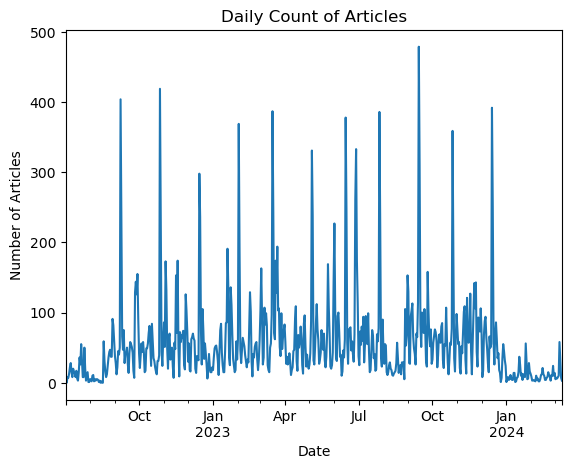

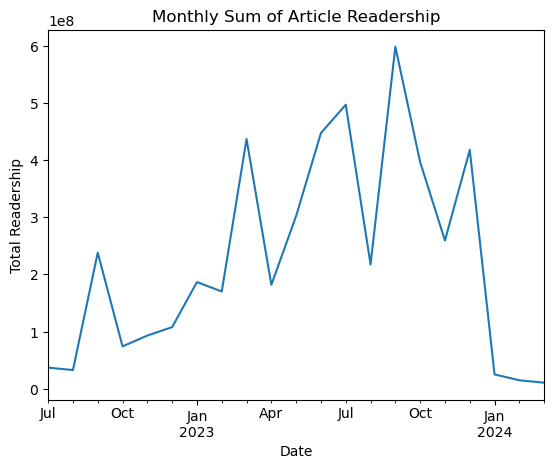

In [154]:

# Convert 'Date' column to datetime, specifying the format if necessary
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Drop rows where 'Date' is NaT (Not a Time) - these might be improperly formatted dates
df = df.dropna(subset=['Date'])

# Check the range and some samples of dates
print("Earliest Date in Data:", df['Date'].min())
print("Most Recent Date in Data:", df['Date'].max())
print("\nSample Dates:")
print(df['Date'].sample(5))

# Find the row with the earliest date
earliest_date_row = df[df['Date'] == df['Date'].min()]

# Find the row with the most recent date
most_recent_date_row = df[df['Date'] == df['Date'].max()]

# Display the results
print("\nRow with the earliest date:")
print(earliest_date_row)

print("\nRow with the most recent date:")
print(most_recent_date_row)

# Set 'Date' as the index of the DataFrame
df.set_index('Date', inplace=True)

# Plot daily count of articles
df.resample('D')['Headline'].count().plot()
plt.title('Daily Count of Articles')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.show()

# Plot monthly sum of article readership
df.resample('M')['Article_Readership'].sum().plot()
plt.title('Monthly Sum of Article Readership')
plt.xlabel('Date')
plt.ylabel('Total Readership')
plt.show()

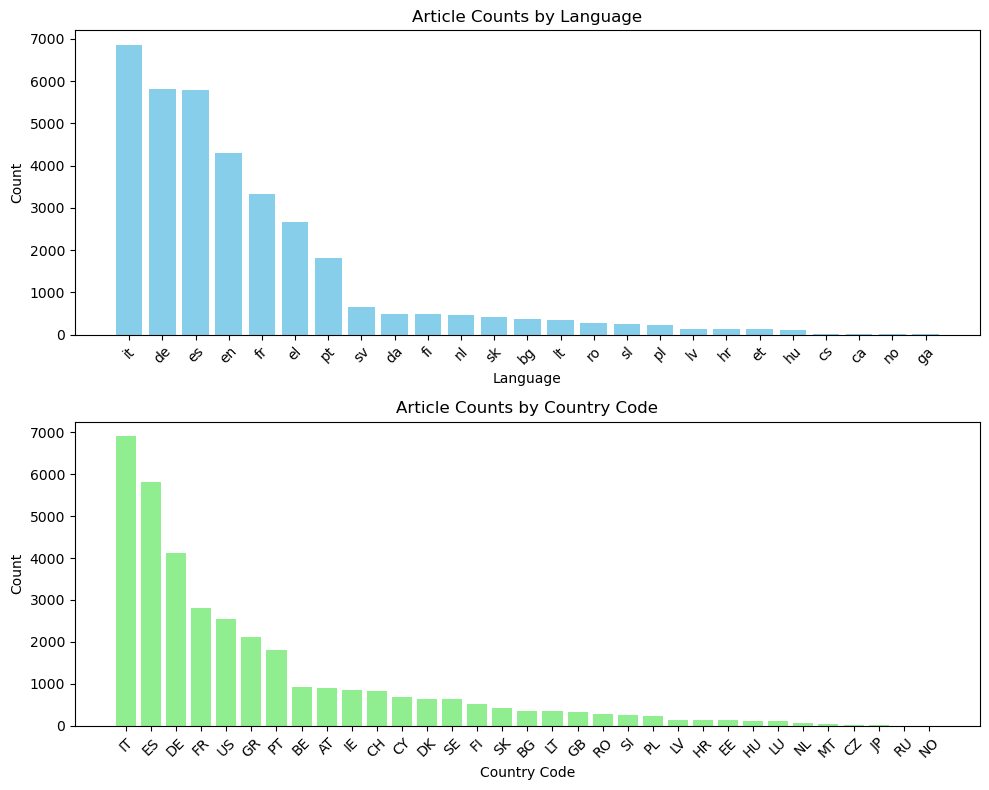

In [42]:
# Count the occurrences for each language
language_counts = df['Language'].value_counts()

# Count the occurrences for each country code
country_code_counts = df['Country.Code'].value_counts()

# Create a figure with two subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Plotting the 'Language' bar plot
axes[0].bar(language_counts.index, language_counts.values, color='skyblue')
axes[0].set_title('Article Counts by Language')
axes[0].set_xlabel('Language')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45) # Rotate x-axis labels for better readability

# Plotting the 'Country.Code' bar plot
axes[1].bar(country_code_counts.index, country_code_counts.values, color='lightgreen')
axes[1].set_title('Article Counts by Country Code')
axes[1].set_xlabel('Country Code')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45) # Rotate x-axis labels for better readability

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

# PreProcess Scraped Text

In [75]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from tqdm import tqdm

In [76]:
df_scraped = pd.read_excel('total_scraped_final.xlsx')
df_scraped.head(20)

url  \
0   http://www.eleconomista.es/economia/noticias/1...   
1   https://expresso.pt/economia/sistema-financeir...   
2   https://finanza.lastampa.it/News/2023/07/10/bc...   
3   https://finanza.tgcom24.mediaset.it/news/detta...   
4   https://finanza.tgcom24.mediaset.it/news/detta...   
5   https://finanza.tgcom24.mediaset.it/news/detta...   
6   https://paper.opoint.com/?id_site=25073&id_art...   
7   https://paper.opoint.com/?id_site=25073&id_art...   
8   https://paper.opoint.com/?id_site=25073&id_art...   
9   https://paper.opoint.com/?id_site=25073&id_art...   
10  https://paper.opoint.com/?id_site=25073&id_art...   
11  https://paper.opoint.com/?id_site=25073&id_art...   
12  https://paper.opoint.com/?id_site=25073&id_art...   
13  https://paper.opoint.com/?id_site=25073&id_art...   
14  https://paper.opoint.com/?id_site=25073&id_art...   
15  https://paper.opoint.com/?id_site=25073&id_art...   
16  https://paper.opoint.com/?id_site=25073&id_art...   
17  https://paper.opoint.com/?id_site=25073&id_art...   
18  https://paper.opoint.com/?id_site=25073&id_art...   
19  https://paper.opoint.com/?id_site=25073&id_art...   

                                Website      Form  \
0            http://www.eleconomista.es  Manually   
1                   https://expresso.pt  Manually   
2           https://finanza.lastampa.it  Manually   
3   https://finanza.tgcom24.mediaset.it  Manually   
4   https://finanza.tgcom24.mediaset.it  Manually   
5   https://finanza.tgcom24.mediaset.it  Manually   
6              https://paper.opoint.com  Manually   
7              https://paper.opoint.com  Manually   
8              https://paper.opoint.com  Manually   
9              https://paper.opoint.com  Manually   
10             https://paper.opoint.com  Manually   
11             https://paper.opoint.com  Manually   
12             https://paper.opoint.com  Manually   
13             https://paper.opoint.com  Manually   
14             https://paper.opoint.com  Manually   
15             https://paper.opoint.com  Manually   
16             https://paper.opoint.com  Manually   
17             https://paper.opoint.com  Manually   
18             https://paper.opoint.com  Manually   
19             https://paper.opoint.com  Manually   

                                      translated_text  top_words_count  
0   The European Central Bank (ECB) meets years, a...              185  
1   It was Mario Centeno's first public interventi...                4  
2   "In the euro area, I believe that we will soon...               20  
3   Milan (MF-DJ)-"A closer European integration i...                4  
4   Milan (MF-DJ)-"There was a recurring request b...                4  
5   Milan (MF-NW)-"Salary pressures are still pres...                4  
6   12Businessberlingske \\urrSection Wednesday /S...               76  
7   16 BusinessBerlingske \\ million N/Two.lin.Sec...               46  
8   10 Businessberlingske \itesSection Friday /two...               72  
9   6Businessberlingske \\\'^ N/Two.lin.Section Fr...               77  
10  9 BusinessBerlingske \\\ N/Two.lin.Section Tue...               59  
11  6 BusinessBerlingske \\Â N/Two.lin.Section Wed...               70  
12  8Businessberlingske \road n/two.lin.Section Th...               69  
13  7 BusinessBerlingske \\\ N/Two.lin.Section Fri...               78  
14  14 BusinessBerlingske \\\ N/Three.lin.Section ...               92  
15  Global 8BusinessBerlingske \\\ N/Two.lin.Secti...               63  
16  6Businessberlingske \road n/two.lin.Section Fr...               61  
17  Realkredit \\\ neighboring/A.Altktor: \\urralt...               85  
18  12 BusinessBerlingske \\\ N/Two.lin.Section Th...               70  
19  12Businessberlingske \\Â N/Two.lin.Section Fri...               60

In [94]:
df_scraped.shape

(25923, 6)

In [114]:
# Download necessary NLTK resources if not already available
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# Prepare the stopwords set once to avoid repeated loading
initial_stop_words = stopwords.words('english')
custom_stopwords = {
    'npagina', 'nfoglio', 'nquotidiano', 'ndi', 'nla', 'ndie', 'nder', 'ne', 'nlos', 'nde', 
    'na', 'nto', 'np', 'nel', 'nque', 'nen', 'ndel', 'cm'
}
stop_words = set(initial_stop_words).union(custom_stopwords)

def clean_text(text):
    """
    Perform initial cleaning of the text by removing URLs, numbers,
    non-alphabetic characters, and converting to lowercase.
    """
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'\b\d+\b', '', text)  # Remove all standalone numbers
    text = re.sub(r'\bn[a-z]{2,}\b', '', text)  # Aggressively remove words starting with 'n' followed by at least two letters
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabet characters
    return text.lower()

def tokenize(text, mode):
    """
    Tokenizes the text based on the given mode.
    Mode 0: Convert text to lowercase.
    Mode 1: Apply stemming.
    Mode 2: Apply lemmatization.
    """
    text = clean_text(text)  # Apply enhanced cleaning
    words = word_tokenize(text)
    if mode == 1:
        stemmer = PorterStemmer()
        words = [stemmer.stem(word) for word in words if word not in stop_words]
    elif mode == 2:
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    else:
        words = [word for word in words if word not in stop_words]

    return ' '.join(words)

def preprocess_texts(data_frame, column_name, mode):
    """
    Apply text preprocessing to a specified column in a DataFrame.
    """
    # Fill NaN values with empty strings before processing
    data_frame[column_name] = data_frame[column_name].fillna('')
    # Use tqdm to display progress while applying preprocessing
    tqdm.pandas(desc="Processing Texts")
    return data_frame[column_name].astype(str).progress_apply(lambda row: tokenize(row, mode))

In [106]:
"""
# Download necessary NLTK resources if not already available
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Prepare the stopwords set once to avoid repeated loading
stop_words = set(stopwords.words('english'))

# Add custom stopwords to the set
custom_stopwords = {'npagina', 'nfoglio', 'nquotidiano', 'ndi', 'nla', 'ndie', 'nder', 'ne', 'nlos', 'nde', 'na', 'nto', 'np', 'nel', 'nque', 'nen', 'ndel', 'cm',}
stop_words.update(custom_stopwords)

def tokenize(text, mode):
    
    Tokenizes the text based on the given mode.
    mode 0: Convert text to lowercase.
    mode 1: Apply stemming.
    mode 2: Apply lemmatization.
    
    # Remove URLs, numbers, and any non-alphabetical characters
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'\b\d+\b', '', text)  # Remove all standalone numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Keep only alphabetical characters
    text = text.lower()  # Convert to lowercase
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]

    if mode == 1:
        stemmer = PorterStemmer()
        words = [stemmer.stem(word) for word in words]
    elif mode == 2:
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word) for word in words]

    return ' '.join(words)

def preprocess_texts(data_frame, column_name, mode):
    # Fill NaN values with empty strings before processing
    data_frame[column_name] = data_frame[column_name].fillna('')
    # Use tqdm to display progress while applying preprocessing
    tqdm.pandas(desc="Processing Texts")  # Initial setup for tqdm with pandas
    return data_frame[column_name].astype(str).progress_apply(lambda row: tokenize(row, mode))
"""


<>:1: DeprecationWarning: invalid escape sequence '\S'
<>:1: DeprecationWarning: invalid escape sequence '\S'
C:\Users\monbi\AppData\Local\Temp\ipykernel_22428\4184123297.py:1: DeprecationWarning: invalid escape sequence '\S'
  """


'\n# Download necessary NLTK resources if not already available\nnltk.download(\'punkt\')\nnltk.download(\'stopwords\')\nnltk.download(\'wordnet\')\n\n# Prepare the stopwords set once to avoid repeated loading\nstop_words = set(stopwords.words(\'english\'))\n\n# Add custom stopwords to the set\ncustom_stopwords = {\'npagina\', \'nfoglio\', \'nquotidiano\', \'ndi\', \'nla\', \'ndie\', \'nder\', \'ne\', \'nlos\', \'nde\', \'na\', \'nto\', \'np\', \'nel\', \'nque\', \'nen\', \'ndel\', \'cm\',}\nstop_words.update(custom_stopwords)\n\ndef tokenize(text, mode):\n    \n    Tokenizes the text based on the given mode.\n    mode 0: Convert text to lowercase.\n    mode 1: Apply stemming.\n    mode 2: Apply lemmatization.\n    \n    # Remove URLs, numbers, and any non-alphabetical characters\n    text = re.sub(r\'http\\S+\', \'\', text)  # Remove URLs\n    text = re.sub(r\'\x08\\d+\x08\', \'\', text)  # Remove all standalone numbers\n    text = re.sub(r\'[^a-zA-Z\\s]\', \'\', text)  # Keep only al

In [115]:
mod = 2  # Set the preprocessing mode to 2 for lemmatizing

# Apply preprocessing to the relevant columns
df_scraped['translated_text_preproc'] = preprocess_texts(df_scraped, 'translated_text', mod)

# Display the result to verify
df_scraped[['Website', 'translated_text_preproc']].head(20)

Processing Texts: 100%|██████████| 25923/25923 [00:54<00:00, 476.87it/s]


Website  \
0            http://www.eleconomista.es   
1                   https://expresso.pt   
2           https://finanza.lastampa.it   
3   https://finanza.tgcom24.mediaset.it   
4   https://finanza.tgcom24.mediaset.it   
5   https://finanza.tgcom24.mediaset.it   
6              https://paper.opoint.com   
7              https://paper.opoint.com   
8              https://paper.opoint.com   
9              https://paper.opoint.com   
10             https://paper.opoint.com   
11             https://paper.opoint.com   
12             https://paper.opoint.com   
13             https://paper.opoint.com   
14             https://paper.opoint.com   
15             https://paper.opoint.com   
16             https://paper.opoint.com   
17             https://paper.opoint.com   
18             https://paper.opoint.com   
19             https://paper.opoint.com   

                              translated_text_preproc  
0   european central bank ecb meet year although r...  
1   mario centenos first public intervention refle...  
2   euro area believe soon reach highest point int...  
3   milan mfdja closer european integration best r...  
4   milan mfdjthere recurring request party r euro...  
5   milan mfnwsalary pressure still present data r...  
6   businessberlingske urrsection wednesday sevenl...  
7   businessberlingske million ntwolinsection wedn...  
8   businessberlingske itessection friday twolinei...  
9   businessberlingske ntwolinsection friday oneli...  
10  businessberlingske ntwolinsection tuesday onel...  
11  businessberlingske ntwolinsection wednesday tw...  
12  businessberlingske road ntwolinsection thursda...  
13  businessberlingske ntwolinsection friday three...  
14  businessberlingske nthreelinsection lord day f...  
15  global businessberlingske ntwolinsection frida...  
16  businessberlingske road ntwolinsection friday ...  
17  realkredit aaltktor urraltnsvaaltrlaltigalt ur...  
18  businessberlingske ntwolinsection thursday two...  
19  businessberlingske ntwolinsection friday three...

In [10]:
"""
def tokenize(text, mode):
    
    Tokenizes the text based on the given mode.
    mode 0: Convert text to lowercase.
    mode 1: Apply stemming.
    mode 2: Apply lemmatization.

    # Basic cleaning
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    text = text.lower()
    words = word_tokenize(text)
    words = [word for word in words if word not in stopwords.words('english')]

    if mode == 1:
        stemmer = PorterStemmer()
        words = [stemmer.stem(word) for word in words]
    elif mode == 2:
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word) for word in words]

    return ' '.join(words)

"""

In [56]:
"""
def preprocess_texts(data_frame, column_name, mode):
    # Fill NaN values with empty strings before processing
    data_frame[column_name] = data_frame[column_name].fillna('')
    return data_frame[column_name].astype(str).progress_apply(lambda row: tokenize(row, mode))
"""

In [21]:
"""
# Assuming your dataframe 'df' is already loaded and includes the necessary columns
mod = 2  # Set the preprocessing mode to 2 for lemmatizing

# Apply preprocessing to the relevant columns
df_scraped['translated_text_preproc'] = preprocess_texts(df, 'translated_text', mod)

# Display the result to verify
df_scraped[['text', 'language', 'translated_text_preproc']].head(20)
"""

  0%|          | 0/16968 [00:00<?, ?it/s]

100%|██████████| 16968/16968 [1:02:12<00:00,  4.55it/s]   


text language  \
0   El vicepresidente del Banco Central Europeo (B...       es   
1   Los bancos centrales no deben luchar solo cont...       es   
2   La presidenta del BCE Christine Lagarde ha asu...       es   
3   La presidenta del Banco Central Europeo, Chris...       es   
4   El vicepresidente del Banco Central Europeo (B...       es   
5   Los inversores han seguido con lupa los detall...       es   
6   La presidenta del Banco Central Europeo (BCE),...       es   
7   El BCE ha decidido hoy su cuarta subida de los...       es   
8   El frio criptoinvierno que azota a los inverso...       es   
9   O Banco Central Europeu (BCE) vai encarecer o ...       pt   
10  As atas da ultima reuniao do Banco Central Eur...       pt   
11  O governador do Banco de Portugal (BdP), Mario...       pt   
12  O Banco Central Europeu (BCE) reune o conselho...       pt   
13  Christine Lagarde, a presidente do Banco Centr...       pt   
14  O conselho do Banco Central Europeu (BCE) deci...       pt   
15  O aumento historico de 75 pontos-base (tres qu...       pt   
16  A presidente do Banco Central Europeu (BCE), C...       pt   
17  O Banco Central Europeu (BCE) devera comecar a...       pt   
18  Mario Centeno nao votou a subida recorde da ta...       pt   
19  "O Banco Central Europeu nunca defendera a opc...       pt   

                              translated_text_preproc  
0   vice president european central bank ecb luis ...  
1   central bank fight current binding spiral pric...  
2   president ecb christine lagarde assumed today ...  
3   president european central bank christine laga...  
4   vice president european central bank ecb luis ...  
5   investor followed detail future mpce monetary ...  
6   president european central bank ecb christine ...  
7   ecb decided today fourth rise type interest an...  
8   cold crypto plague investor digital asset seem...  
9   european central bank ecb establish financing ...  
10  minute last meeting european central bank ecb ...  
11  governor banco de portugal bdp mario centeno d...  
12  european central bank ecb gather council thurs...  
13  christine lagarde president european central b...  
14  european central bank council ecb decided thur...  
15  historical increase base point three room perc...  
16  president european central bank ecb christine ...  
17  european central bank ecb start debating octob...  
18  mario centeno vote recording rise european cen...  
19  european central bank never defended euro outp...

In [126]:
from sklearn.feature_extraction.text import CountVectorizer
from gensim import corpora, models
from gensim.matutils import Sparse2Corpus

In [127]:
def vectorize_text(data, column_name, max_features=1000):
    vectorizer = CountVectorizer(max_df=0.5, min_df=0.01, stop_words='english', max_features=max_features)
    dtm = vectorizer.fit_transform(data[column_name])
    return dtm, vectorizer

In [128]:
def dtm_to_gensim(dtm):
    return Sparse2Corpus(dtm, documents_columns=False)

In [129]:
def run_lda(corpus, id2word, num_topics=10, passes=10):
    lda_model = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, passes=passes, random_state=100)
    return lda_model

In [130]:
def display_topics(lda_model):
    print("Top words associated with each topic (LDA):")
    topics = lda_model.show_topics(num_words=10, formatted=False)
    for topic_num, topic_words in topics:
        words = ', '.join([word for word, _ in topic_words])
        print(f"Topic {topic_num + 1}: {words}")

In [136]:
# Define the function to convert DTM to Gensim corpus
#def dtm_to_gensim(dtm):
#    return Sparse2Corpus(dtm, documents_columns=False)

# Vectorize the preprocessed text data
dtm, vectorizer = vectorize_text(df_scraped, 'translated_text_preproc', max_features=1000)

# Convert to Gensim corpus and prepare dictionary
corpus = dtm_to_gensim(dtm)
id2word = {i: word for i, word in enumerate(vectorizer.get_feature_names_out())}

# Run LDA
lda_model = run_lda(corpus, id2word, num_topics=10, passes=10)

# Display the topics
display_topics(lda_model)


Top words associated with each topic (LDA):
Topic 1: italy, cent, italian, government, billion, bond, spread, visco, yield, panetta
Topic 2: lagarde, point, monetary, meeting, policy, market, president, basis, christine, decision
Topic 3: said, policy, price, monetary, member, hike, high, ecbs, point, target
Topic 4: president, country, lagarde, government, economy, time, policy, minister, europe, economic
Topic 5: mortgage, euribor, variable, article, month, fixed, right, medium, reserved, loan
Topic 6: financial, banking, risk, market, credit, sector, debt, guindos, crisis, stability
Topic 7: type, spain, eur, salary, entity, rise, author, value, spanish, area
Topic 8: price, market, month, point, energy, growth, data, stock, economy, expected
Topic 9: percent, price, high, time, according, key, area, market, money, economy
Topic 10: digital, payment, currency, cash, member, board, money, panetta, use, project


## Analysis of Each Topic:

### Topic 1: Italian Economic Indicators
- **Focus:** Italy's economic measures, including government bonds and key figures like Visco and Panetta, who are influential in the Italian banking sector.

### Topic 2: ECB Monetary Policy
- **Focus:** Centered around ECB's leadership (Lagarde) and monetary policy decisions, reflecting discussions from policy meetings.

### Topic 3: Monetary Policy and Inflation
- **Focus:** Addresses monetary policy adjustments in response to inflation targets, indicating a focus on policy responses to economic conditions.

### Topic 4: European Leadership and Economy
- **Focus:** Mixes political and economic discourse, involving high-level discussions on government policies and economic strategies within Europe.

### Topic 5: Mortgage and Housing Market
- **Focus:** Discusses mortgage rates (variable and fixed), particularly focusing on the financial products and legal rights, indicating articles related to housing finance.

### Topic 6: Financial Sector Stability
- **Focus:** Deals with the banking sector, emphasizing financial stability, risk management, and the roles of key figures like Guindos.

### Topic 7: Spanish Economic Details
- **Focus:** Focuses on specific economic issues within Spain, including salaries and corporate matters, suggesting a regional economic focus.

### Topic 8: Economic Growth and Energy
- **Focus:** Encompasses broader economic indicators and market analytics, including energy prices and growth metrics.

### Topic 9: General Economic Indicators
- **Focus:** Similar to Topic 8 but more focused on price levels and monetary discussions, showing overlap with general economic conditions.

### Topic 10: Digital Finance
- **Focus:** Reflects the growing focus on digital payment systems, cryptocurrencies, and related financial innovations, highlighting ECB's interest in digital currency projects.


In [122]:
from gensim import corpora

# Create a new Gensim dictionary
gensim_dictionary = corpora.Dictionary()

# Assuming 'id2word' is your Python dictionary that maps IDs to tokens
gensim_dictionary.id2token = id2word
gensim_dictionary.token2id = {v: k for k, v in id2word.items()}

In [123]:
# Print some dictionary items to confirm
for i, word in list(gensim_dictionary.items())[:10]:
    print(i, word)

0 able
1 access
2 according
3 account
4 achieve
5 achieved
6 act
7 action
8 activity
9 actually


In [124]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Assuming 'lda_model' and 'corpus' are already defined
lda_display = gensimvis.prepare(lda_model, corpus, dictionary=gensim_dictionary, sort_topics=False)

# Display in a Jupyter Notebook
pyLDAvis.display(lda_display)

# Pre-Processing (2nd Attempt)

In [5]:
def tokenize(text, mode):
    """
    Tokenizes the text based on the given mode.
    mode 0: Convert text to lowercase.
    mode 1: Apply stemming.
    mode 2: Apply lemmatization.
    """
    # Basic cleaning
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    text = text.lower()
    words = word_tokenize(text)
    words = [word for word in words if word not in stopwords.words('english')]

    if mode == 1:
        stemmer = PorterStemmer()
        words = [stemmer.stem(word) for word in words]
    elif mode == 2:
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word) for word in words]

    return ' '.join(words)

In [11]:
def preprocess_texts(data_frame, column_name, mode):
    # Fill NaN values with empty strings before processing
    data_frame[column_name] = data_frame[column_name].fillna('')
    return data_frame[column_name].astype(str).progress_apply(lambda row: tokenize(row, mode))

In [12]:
# Assuming your dataframe 'df' is already loaded and includes the necessary columns
mod = 2  # Set the preprocessing mode to 2 for lemmatizing

# Apply preprocessing to the relevant columns
df['Translated_headline_preproc'] = preprocess_texts(df, 'Translated.headline', mod)
df['Manual_summary_preproc'] = preprocess_texts(df, 'Manual.summary', mod)

# Display the result to verify
df[['Translated.headline', 'Translated_headline_preproc', 'Manual.summary', 'Manual_summary_preproc']].head(20)

  0%|          | 0/35076 [00:00<?, ?it/s]

100%|██████████| 35076/35076 [11:06<00:00, 52.61it/s] 


Translated.headline  \
Date                                                                     
2022-09-30 22:08:34  Banca d'Italia's Visco: "Too many rate hikes w...   
2022-09-30 21:44:15       Knot: further  ECB  rate hikes are necessary   
2022-09-30 21:30:13  ECB 's Visco: Recession risk in the event of m...   
2022-09-30 21:07:32  ECB  should be cautious about rate hikes, says...   
2022-09-30 20:56:08  ECB 's Schnabel says weaker demand may not eas...   
2022-09-30 19:47:02  ECB  Executive Board Member Schnabel is for "r...   
2022-09-30 19:17:43  Visco: "Energy shock is an unavoidable burden....   
2022-09-30 19:11:05       ECB : Schnabel, further rate hikes necessary   
2022-09-30 19:11:05  ECB : Schnabel sees no risk of spiraling wages...   
2022-09-30 18:53:08  ECB  monetary policy: Council member Visco war...   
2022-09-30 18:46:15     Energy: Visco, inescapable shock for euro area   
2022-09-30 18:42:47  Public accounts: Visco, debt repayment well ad...   
2022-09-30 18:39:39  Public accounts: Visco, debt repayment well ad...   
2022-09-30 18:32:37  Euro area inflation on a new record. Will the ...   
2022-09-30 18:25:42  ECB , Visco: “it is appropriate to move gradua...   
2022-09-30 18:25:13  ECB  Executive Board Member Schnabel calls for...   
2022-09-30 18:23:18  Inflation: Visco, no signs start dangerous pri...   
2022-09-30 18:23:02  ECB : Visco, when rising rates it is appropria...   
2022-09-30 18:19:40  ECB , Visco: too rapid and strong rate hike ca...   
2022-09-30 18:12:29  ECB : Visco, did not delay monetary policy reb...   

                                           Translated_headline_preproc  \
Date                                                                     
2022-09-30 22:08:34  banca ditalias visco many rate hike would trig...   
2022-09-30 21:44:15                       knot ecb rate hike necessary   
2022-09-30 21:30:13  ecb visco recession risk event major interest ...   
2022-09-30 21:07:32                   ecb cautious rate hike say italy   
2022-09-30 20:56:08  ecb schnabel say weaker demand may ease price ...   
2022-09-30 19:47:02  ecb executive board member schnabel robust action   
2022-09-30 19:17:43   visco energy shock unavoidable burden wrong debt   
2022-09-30 19:11:05                   ecb schnabel rate hike necessary   
2022-09-30 19:11:05         ecb schnabel see risk spiraling wage price   
2022-09-30 18:53:08  ecb monetary policy council member visco warns...   
2022-09-30 18:46:15           energy visco inescapable shock euro area   
2022-09-30 18:42:47  public account visco debt repayment well addre...   
2022-09-30 18:39:39  public account visco debt repayment well addre...   
2022-09-30 18:32:37  euro area inflation new record ecb confirm ano...   
2022-09-30 18:25:42     ecb visco appropriate move gradually rate hike   
2022-09-30 18:25:13  ecb executive board member schnabel call vigor...   
2022-09-30 18:23:18  inflation visco sign start dangerous pricewage...   
2022-09-30 18:23:02   ecb visco rising rate appropriate move gradually   
2022-09-30 18:19:40  ecb visco rapid strong rate hike increase rece...   
2022-09-30 18:12:29        ecb visco delay monetary policy rebalancing   

                                                        Manual.summary  \
Date                                                                     
2022-09-30 22:08:34  At a conference in Florence, Banca d'Italia Go...   
2022-09-30 21:44:15                                                      
2022-09-30 21:30:13  Banca d'Italia Governor  Ignazio Visco  on Fri...   
2022-09-30 21:07:32                                                      
2022-09-30 20:56:08  ECB  Executive Board Member  Isabel Schnabel  ...   
2022-09-30 19:47:02                                                      
2022-09-30 19:17:43                                                      
2022-09-30 19:11:05                                                      
2022-09-30 19:11:05                                  

In [13]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from gensim import corpora, models
from gensim.matutils import Sparse2Corpus


In [14]:
def vectorize_text(data, column_name, max_features=1000):
    vectorizer = CountVectorizer(max_df=0.5, min_df=0.01, stop_words='english', max_features=max_features)
    dtm = vectorizer.fit_transform(data[column_name])
    return dtm, vectorizer


In [15]:
def dtm_to_gensim(dtm):
    # Convert sparse matrix to gensim corpus
    corpus = Sparse2Corpus(dtm, documents_columns=False)
    return corpus


In [16]:
def run_lda(corpus, id2word, num_topics=10, passes=10):
    lda_model = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, passes=passes, random_state=100)
    return lda_model


In [17]:
def display_topics(lda_model):
    print("Top words associated with each topic (LDA):")
    topics = lda_model.show_topics(num_words=10, formatted=False)
    for topic_num, topic_words in topics:
        words = ', '.join([word for word, _ in topic_words])
        print(f"Topic {topic_num + 1}: {words}")


In [18]:
"""
def display_enhanced_topics(lda_model, feature_names, no_top_words=10):
    topics = lda_model.show_topics(num_topics=lda_model.num_topics, num_words=no_top_words, formatted=False)
    for topic_idx, topic in enumerate(topics):
        # Extracting words from each topic
        topic_words = [word for word, prob in topic[1]]
        print(f"Topic {topic_idx + 1}: {', '.join(topic_words)}")
        print("Potential Interpretation: Discusses aspects related to ... based on terms such as ...")
        print("\n")
"""


In [19]:
def display_document_topics(lda_model, corpus, texts, num_topics=10):
    for i, (topics, text) in enumerate(zip(lda_model[corpus], texts)):
        print(f"Document {i}:")
        print(f"Text: {text[:100]}...")  # Showing a snippet of the text
        sorted_topics = sorted(topics, key=lambda x: x[1], reverse=True)
        for topic_num, prop_topic in sorted_topics:
            if prop_topic > 0.1:  # Only significant contributions
                print(f"Topic {topic_num + 1}: {prop_topic*100:.1f}%")
        print("\n")

In [21]:
# Vectorize the preprocessed text data
dtm, vectorizer = vectorize_text(df, 'Manual_summary_preproc', max_features=1000)

# Convert to Gensim corpus and prepare dictionary
corpus = dtm_to_gensim(dtm)
id2word = {i: word for i, word in enumerate(vectorizer.get_feature_names_out())}

# Run LDA
lda_model = run_lda(corpus, id2word, num_topics=10, passes=10)

# Display the topics
display_topics(lda_model)
display_enhanced_topics(lda_model, vectorizer.get_feature_names_out(), 10)
display_document_topics(lda_model, corpus, df['Manual_summary_preproc'].fillna("").tolist(), 10)


Top words associated with each topic (LDA):
Topic 1: bank, bond, eur, billion, debt, year, balance, yield, deposit, pepp
Topic 2: euro, area, year, price, month, growth, expected, according, forecast, data
Topic 3: governor, mr, nagel, said, villeroy, galhau, bundesbank, france, deutsche, banque
Topic 4: lagarde, bank, european, financial, christine, banking, stability, market, euro, said
Topic 5: lagarde, hike, meeting, christine, point, council, governing, decision, cut, basis
Topic 6: guindos, economic, price, wage, economy, increase, growth, policy, risk, mr
Topic 7: lagarde, bank, central, reserve, market, christine, federal, cut, policy, monetary
Topic 8: board, euro, digital, executive, member, schnabel, panetta, isabel, fabio, currency
Topic 9: mr, governor, minister, banco, banca, ditalia, government, italy, italian, visco
Topic 10: said, level, target, mr, bank, policy, long, monetary, lane, central
Topic 1: bank, bond, eur, billion, debt, year, balance, yield, deposit, pepp


### Analyzing the LDA Output:

- **Topic 1:** Focuses on financial terms and instruments like bonds, debts, and yields, possibly relating to ECB's financial operations or market interventions.
- **Topic 2:** Appears to be about macroeconomic indicators within the euro area, like growth forecasts and price data.
- **Topic 3:** Could be centered around comments or actions from specific central bank governors or monetary officials.
- **Topic 4 and Topic 5:** Involve Christine Lagarde, highlighting her influence and specific decisions or statements during meetings.
- **Topic 6:** Discusses broader economic issues, including wages and economic policy implications.
- **Topic 7:** Relates to broader central banking functions, potentially comparing ECB with other central banks like the Federal Reserve.
- **Topic 8:** Discusses the European Central Bank's executive board and digital currency initiatives.
- **Topic 9:** Seems focused on Italian financial matters, particularly involving Banca d'Italia and its governor.
- **Topic 10:** Discusses general monetary policy targets and decisions.


In [22]:
from gensim import corpora

# Create a new Gensim dictionary
gensim_dictionary = corpora.Dictionary()

# Assuming 'id2word' is your Python dictionary that maps IDs to tokens
gensim_dictionary.id2token = id2word
gensim_dictionary.token2id = {v: k for k, v in id2word.items()}


In [23]:
# Print some dictionary items to confirm
for i, word in list(gensim_dictionary.items())[:10]:
    print(i, word)


0 ability
1 able
2 according
3 account
4 achieve
5 acknowledged
6 act
7 action
8 activity
9 add


In [28]:
!pip install pyLDAvis

In [29]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Assuming 'lda_model' and 'corpus' are already defined
lda_display = gensimvis.prepare(lda_model, corpus, dictionary=gensim_dictionary, sort_topics=False)

# Display in a Jupyter Notebook
pyLDAvis.display(lda_display)


# Pre-Processing (1st Attempt)

In [ ]:
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import PorterStemmer, download
from nltk.corpus import stopwords
import re

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\monbi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\monbi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\monbi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')  # Download if you plan to tokenize

class TextAnalyzer:
    def __init__(self, dataframe):
        self.df_preprocessed = dataframe
        # Handle missing values right in the constructor to ensure no further issues
        self.df_preprocessed['Manual.summary'].fillna('No summary available', inplace=True)

    @staticmethod
    def remove_html_tags(text):
        pattern = re.compile('<.*?>')
        return pattern.sub('', text)

    def preprocess_text(self, text):
        # Lowercasing
        text = text.lower()
        # Remove HTML tags
        text = self.remove_html_tags(text)
        # Remove special characters and punctuation
        text = re.sub(r'[^\w\s]+', '', text)
        # Remove numbers (optional, uncomment if needed)
        # text = re.sub(r'\d+', '', text)
        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        text = ' '.join([word for word in text.split() if word not in stop_words])
        # Stemming
        stemmer = PorterStemmer()
        text = ' '.join([stemmer.stem(word) for word in text.split()])
        # Remove extra spaces
        text = text.strip()
        return text

    def apply_preprocessing(self):
        self.df_preprocessed['cleaned_text'] = self.df_preprocessed['Manual.summary'].apply(self.preprocess_text)

# Load the data
df_preprocessed = pd.read_excel('combined.xlsx')

# Create an instance of TextAnalyzer with the preprocessed dataframe
text_analyzer = TextAnalyzer(df_preprocessed)
text_analyzer.apply_preprocessing()

# Display the first 20 rows to verify the preprocessing
df_preprocessed.head(20)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\monbi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\monbi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Date                             Source  \
0  2022-09-30 22:08:34     Il Messaggero - Borsa Italiana   
1  2022-09-30 21:44:15  Puls Biznesu - Z ostatniej chwili   
2  2022-09-30 21:30:13            Handelsblatt - Finanzen   
3  2022-09-30 21:07:32                     Trend - Správy   
4  2022-09-30 20:56:08                  Bloomberg - GNews   
5  2022-09-30 19:47:02                      Trend. - Home   
6  2022-09-30 19:17:43  Rai News 24  - Economia e finanza   
7  2022-09-30 19:11:05                            Tgcom24   
8  2022-09-30 19:11:05                            Tgcom24   
9  2022-09-30 18:53:08                       Der Aktionär   
10 2022-09-30 18:46:15                            Tgcom24   
11 2022-09-30 18:42:47                 Il Foglio - Page 3   
12 2022-09-30 18:39:39  Affaritaliani Libero - Notiziario   
13 2022-09-30 18:32:37                  Finance.si - Live   
14 2022-09-30 18:25:42                 Il Foglio - Page 3   
15 2022-09-30 18:25:13            Handelsblatt - Finanzen   
16 2022-09-30 18:23:18                            Tgcom24   
17 2022-09-30 18:23:02  Affaritaliani Libero - Notiziario   
18 2022-09-30 18:19:40                 Il Foglio - Page 2   
19 2022-09-30 18:12:29                            Tgcom24   

                                             Headline  \
0   Visco: «Troppi rialzi dei tassi, si va in rece...   
1      Knot: kolejne podwyżki stóp  EBC  są konieczne   
2   EZB-Ratsmitglied Visco: Rezessionsrisiko bei g...   
3   ECB  by mala byť pri zvyšovaní sadzieb opatrná...   
4   ECB 's Schnabel Says Weaker Demand May Not Eas...   
5      EZB-Direktorin Schnabel für "robustes" Handeln   
6   Visco: "Lo shock energetico è un onere ineludi...   
7   Bce: Schnabel, necessari ulteriori rialzi dei ...   
8   Bce: Schnabel non vede rischio spirale salari-...   
9   EZB ‑Geldpolitik: Ratsmitglied Visco warnt vor...   
10    Energia: Visco, shock ineludibile per area euro   
11  **Conti pubblici: Visco, rientro debito ben in...   
12  **Conti pubblici: Visco, rientro debito ben in...   
13  Evrska inflacija na novem rekordu. Bo  ECB  ok...   
14  Bce: Visco, 'su rialzo tassi opportuno muovers...   
15  EZB-Direktorin Schnabel fordert wegen Rekordin...   
16  Inflazione: Visco, no segnali avvio pericolose...   
17  Bce: Visco, 'su rialzo tassi opportuno muovers...   
18  **Bce: Visco, 'rialzo tassi troppo rapido e fo...   
19  Bce: Visco, non ha ritardato riequilibrio poli...   

                                  Translated.headline  \
0   Banca d'Italia's Visco: "Too many rate hikes w...   
1        Knot: further  ECB  rate hikes are necessary   
2   ECB 's Visco: Recession risk in the event of m...   
3   ECB  should be cautious about rate hikes, says...   
4   ECB 's Schnabel says weaker demand may not eas...   
5   ECB  Executive Board Member Schnabel is for "r...   
6   Visco: "Energy shock is an unavoidable burden....   
7        ECB : Schnabel, further rate hikes necessary   
8   ECB : Schnabel sees no risk of spiraling wages...   
9   ECB  monetary policy: Council member Visco war...   
10     Energy: Visco, inescapable shock for euro area   
11  Public accounts: Visco, debt repayment well ad...   
12  Public accounts: Visco, debt repayment well ad...   
13  Euro area inflation on a new record. Will the ...   
14  ECB , Visco: “it is appropriate to move gradua...   
15  ECB  Executive Board Member Schnabel calls for...   
16  Inflation: Visco, no signs start dangerous pri...   
17  ECB : Visco, when rising rates it is appropria...   
18  ECB , Visco: too rapid and strong rate hike ca...   
19  ECB : Visco, did not delay monetary policy reb...   

                                       Manual.summary  \
0   At a conference in Florence, Banca d'Italia Go...   
1                                No summary available   
2   Banca d'Italia Governor  Ignazio Visco  on Fri...   
3                                No summary available   
4   ECB  Executive Board Member  Isabel Schnabel  ...  

In [ ]:
# Function to clean text
def clean_text(text):
    # Lowercase conversion
    text = text.lower()
    
    # Removing special characters and digits
    text = re.sub(r'[\d]', ' ', text)  # Remove digits
    text = re.sub(r'[^\w\s]', ' ', text)  # Remove punctuation

    # Tokenization
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Join words back into one string
    text = ' '.join(tokens)
    return text

In [ ]:
# Apply text cleaning
df['cleaned_summary'] = df['Manual.summary'].apply(clean_text)

# Feature Extraction with TF-IDF
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_summary'])

# Output the shape of the TF-IDF matrix
print(tfidf_matrix.shape)

# Display the first 20 rows of the DataFrame to check the cleaned summaries
df.head(20)

(35076, 23056)


Source  \
Date                                                     
2022-09-30 22:08:34     Il Messaggero - Borsa Italiana   
2022-09-30 21:44:15  Puls Biznesu - Z ostatniej chwili   
2022-09-30 21:30:13            Handelsblatt - Finanzen   
2022-09-30 21:07:32                     Trend - Správy   
2022-09-30 20:56:08                  Bloomberg - GNews   
2022-09-30 19:47:02                      Trend. - Home   
2022-09-30 19:17:43  Rai News 24  - Economia e finanza   
2022-09-30 19:11:05                            Tgcom24   
2022-09-30 19:11:05                            Tgcom24   
2022-09-30 18:53:08                       Der Aktionär   
2022-09-30 18:46:15                            Tgcom24   
2022-09-30 18:42:47                 Il Foglio - Page 3   
2022-09-30 18:39:39  Affaritaliani Libero - Notiziario   
2022-09-30 18:32:37                  Finance.si - Live   
2022-09-30 18:25:42                 Il Foglio - Page 3   
2022-09-30 18:25:13            Handelsblatt - Finanzen   
2022-09-30 18:23:18                            Tgcom24   
2022-09-30 18:23:02  Affaritaliani Libero - Notiziario   
2022-09-30 18:19:40                 Il Foglio - Page 2   
2022-09-30 18:12:29                            Tgcom24   

                                                              Headline  \
Date                                                                     
2022-09-30 22:08:34  Visco: «Troppi rialzi dei tassi, si va in rece...   
2022-09-30 21:44:15     Knot: kolejne podwyżki stóp  EBC  są konieczne   
2022-09-30 21:30:13  EZB-Ratsmitglied Visco: Rezessionsrisiko bei g...   
2022-09-30 21:07:32  ECB  by mala byť pri zvyšovaní sadzieb opatrná...   
2022-09-30 20:56:08  ECB 's Schnabel Says Weaker Demand May Not Eas...   
2022-09-30 19:47:02     EZB-Direktorin Schnabel für "robustes" Handeln   
2022-09-30 19:17:43  Visco: "Lo shock energetico è un onere ineludi...   
2022-09-30 19:11:05  Bce: Schnabel, necessari ulteriori rialzi dei ...   
2022-09-30 19:11:05  Bce: Schnabel non vede rischio spirale salari-...   
2022-09-30 18:53:08  EZB ‑Geldpolitik: Ratsmitglied Visco warnt vor...   
2022-09-30 18:46:15    Energia: Visco, shock ineludibile per area euro   
2022-09-30 18:42:47  **Conti pubblici: Visco, rientro debito ben in...   
2022-09-30 18:39:39  **Conti pubblici: Visco, rientro debito ben in...   
2022-09-30 18:32:37  Evrska inflacija na novem rekordu. Bo  ECB  ok...   
2022-09-30 18:25:42  Bce: Visco, 'su rialzo tassi opportuno muovers...   
2022-09-30 18:25:13  EZB-Direktorin Schnabel fordert wegen Rekordin...   
2022-09-30 18:23:18  Inflazione: Visco, no segnali avvio pericolose...   
2022-09-30 18:23:02  Bce: Visco, 'su rialzo tassi opportuno muovers...   
2022-09-30 18:19:40  **Bce: Visco, 'rialzo tassi troppo rapido e fo...   
2022-09-30 18:12:29  Bce: Visco, non ha ritardato riequilibrio poli...   

                                                   Translated.headline  \
Date                                                                     
2022-09-30 22:08:34  Banca d'Italia's Visco: "Too many rate hikes w...   
2022-09-30 21:44:15       Knot: further  ECB  rate hikes are necessary   
2022-09-30 21:30:13  ECB 's Visco: Recession risk in the event of m...   
2022-09-30 21:07:32  ECB  should be cautious about rate hikes, says...   
2022-09-30 20:56:08  ECB 's Schnabel says weaker demand may not eas...   
2022-09-30 19:47:02  ECB  Executive Board Member Schnabel is for "r...   
2022-09-30 19:17:43  Visco: "Energy shock is an unavoidable burden....   
2022-09-30 19:11:05       ECB : Schnabel, further rate hikes necessary   
2022-09-30 19:11:05  ECB : Schnabel sees no risk of spiraling wages...   
2022-09-30 18:53:08  ECB  monetary policy: Council member Visco war...   
2022-09-30 18:46:15     Energy: Visco, inescapable shock for euro area   
2022-09-30 18:42:47  Public accounts: Visco, debt repayment well ad...   
2022-09-30 18:39:39  Public accounts: Visco, debt repayment well ad...   
2022-09-30 18:32:37  Euro area i

In [ ]:
!pip install langdetect

     ---------------------------------------- 0.0/981.5 kB ? eta -:--:--
     ---------------------------------------- 10.2/981.5 kB ? eta -:--:--
     ---- --------------------------------- 112.6/981.5 kB 1.3 MB/s eta 0:00:01
     --------------------------- ---------- 706.6/981.5 kB 6.4 MB/s eta 0:00:01
     -------------------------------------  972.8/981.5 kB 6.2 MB/s eta 0:00:01
     -------------------------------------- 981.5/981.5 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993253 sha256=1ed281ebf1dcca3c93a1725a3b70771a36004906faf4b04f86306f3ab0086e63
  Stored in directory: c:\users\monbi\appdata\local\pip\cache\wheels\0a\f2\b2\e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect


In [ ]:
from langdetect import detect
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from gensim.matutils import Sparse2Corpus
from gensim import models, corpora
from scipy.sparse import csr_matrix
import re
import tqdm

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

# Define the tokenize function
def tokenize(text, mode):
    stemmer = PorterStemmer()
    tokens = nltk.word_tokenize(text)
    tokens = [token.lower() for token in tokens if token.isalpha()]  # Lowercasing and alpha filter
    if mode == 1:
        tokens = [stemmer.stem(token) for token in tokens]  # Stemming
    elif mode == 2:
        lemmatizer = nltk.WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]  # Lemmatizing
    return ' '.join(tokens)

# Initialize non-English count
non_en_count = 0

# Convert column to string and check language
df_preprocessed['Manual.summary'] = df_preprocessed['Manual.summary'].astype(str)  # Ensure all data is string type

for index, row in df_preprocessed.iterrows():
    lang = detect(row['text'])
    if lang != 'en':
        non_en_count += 1
print(f'Number of non-English articles: {non_en_count}')

# Preprocess text
df_preprocessed['text_preproc'] = df_preprocessed['Manual.summary'].apply(lambda x: tokenize(x, 2))  # mode 2 for lemmatizing
df_preprocessed['title_preproc'] = df_preprocessed['Title'].apply(lambda x: tokenize(x, 2))  # Adjust 'Title' if needed

# Example function to run analysis, vectorization and topic modeling
def run_and_log_analyses(dataframe, output_file):
    with open(output_file, "w") as file:
        # Setup CountVectorizer and TfidfVectorizer
        cv = CountVectorizer(min_df=0.01, max_df=0.5)
        tfidf = TfidfVectorizer(min_df=0.01, max_df=0.5)

        # Apply vectorization
        text_cv = cv.fit_transform(dataframe['text_preproc'])
        title_cv = cv.transform(dataframe['title_preproc'])
        text_tfidf = tfidf.fit_transform(dataframe['text_preproc'])
        title_tfidf = tfidf.transform(dataframe['title_preproc'])

        # Apply SVD
        svd_model = TruncatedSVD(n_components=10)
        text_svd = svd_model.fit_transform(text_cv)
        title_svd = svd_model.transform(title_cv)

        # Perform topic modeling with LDA
        lda_model = models.LdaModel(corpus=Sparse2Corpus(text_cv, documents_columns=False), num_topics=10, passes=10, id2word=dict((id, word) for word, id in cv.vocabulary_.items()))
        topics = lda_model.print_topics(num_words=10)
        for topic in topics:
            file.write(f"Topic: {topic}\n")

# Run the analyses and log results
run_and_log_analyses(df_preprocessed, "analysis_results.txt")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\monbi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\monbi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


KeyError: 'text'